# Train the network
#### Define the NN architecture and train it

## Setup

In [1]:
import numpy as np
import pandas as pd
seed = 7
np.random.seed(seed)
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, merge, Concatenate
from keras.models import Model
import time

Using TensorFlow backend.


In [2]:
radius = 'ak5' # Jet radius to use. Either 'ak5' or 'ak7'

In [3]:
####################
# Global Variables #
####################
nx = 25 if radius == 'ak5' else 30 # size of image in eta
ny = 25 if radius == 'ak5' else 30 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

### Load and process data

In [4]:
df_jets_train = pd.read_pickle('data/{}/df_jets_{}_train.pkl'.format(radius, radius))
df_jets_val = pd.read_pickle('data/{}/df_jets_{}_val.pkl'.format(radius, radius))

print('Training events = {}, Validation events = {}'.format(df_jets_train.shape[0], df_jets_val.shape[0]))

Training events = 2872606, Validation events = 319179


### Define the model

In [5]:
model_name = 'dense_pteta'

In [6]:
input_layer = Input(shape=(2,))

layer = Dense(32, activation='relu')(input_layer)
layer = Dense(32, activation='relu')(layer)
layer = Dense(32, activation='relu')(layer)

output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mape','msle'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
main_output (Dense)          (None, 1)                 33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


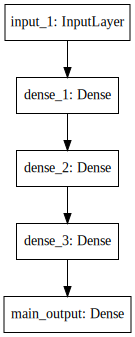

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('models/'+radius+'/'+model_name+'_epoch{epoch:02d}_valloss{val_loss:.6f}.h5', 
                             monitor='val_loss', save_best_only=True)
bs=256

### Train the model

In [9]:
start = time.clock()
history = model.fit(df_jets_train[['scaled_pt','jet_eta']].values, df_jets_train['jet_resp'],
                    validation_data=(df_jets_val[['scaled_pt','jet_eta']].values, df_jets_val['jet_resp']),
                    epochs=400, batch_size=bs, verbose=1, 
                    callbacks=[early_stopping, checkpoint])
end = time.clock()

print('Training took {:.2f} minutes'.format((end-start)/60.))

Train on 2872606 samples, validate on 319179 samples
Epoch 1/400
2872606/2872606 [==============================] - 52s 18us/step - loss: 0.0114 - mean_absolute_percentage_error: 7.6412 - mean_squared_logarithmic_error: 0.0032 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 7.4376 - val_mean_squared_logarithmic_error: 0.0025
Epoch 2/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0094 - mean_absolute_percentage_error: 7.3317 - mean_squared_logarithmic_error: 0.0024 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 7.6613 - val_mean_squared_logarithmic_error: 0.0026
Epoch 3/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0094 - mean_absolute_percentage_error: 7.3194 - mean_squared_logarithmic_error: 0.0024 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.3375 - val_mean_squared_logarithmic_error: 0.0024
Epoch 4/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0094 - mean

Epoch 30/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0093 - mean_absolute_percentage_error: 7.2896 - mean_squared_logarithmic_error: 0.0024 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.3235 - val_mean_squared_logarithmic_error: 0.0024
Epoch 31/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0093 - mean_absolute_percentage_error: 7.2892 - mean_squared_logarithmic_error: 0.0024 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.3176 - val_mean_squared_logarithmic_error: 0.0024
Epoch 32/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0093 - mean_absolute_percentage_error: 7.2887 - mean_squared_logarithmic_error: 0.0024 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.3388 - val_mean_squared_logarithmic_error: 0.0024
Epoch 33/400
2872606/2872606 [==============================] - 51s 18us/step - loss: 0.0093 - mean_absolute_percentage_error: 7.2885 - mean_squared

In [10]:
model.save('models/{}/{}_{}_trained.h5'.format(radius, model_name, radius))## Results

## Results

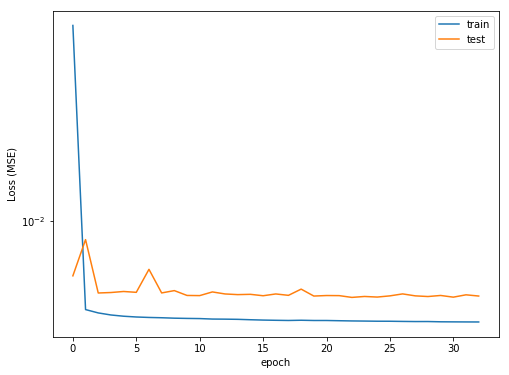

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))

loss = np.asarray(history.history['loss'])
val_loss = np.asarray(history.history['val_loss'])
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

plt.savefig('plots/{}/train_val_loss_{}_{}.pdf'.format(radius, radius, model_name))

#### Make predictions

In [12]:
true_train = df_jets_train['jet_resp']
pred_train = model.predict(df_jets_train[['scaled_pt','jet_eta']].values)

true_val = df_jets_val['jet_resp']
pred_val = model.predict(df_jets_val[['scaled_pt','jet_eta']].values)

#### Calculate metrics

In [13]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(true_train, pred_train)
mse_val = mean_squared_error(true_val, pred_val)

residual_train = (true_train - pred_train[:,0])/true_train
residual_val = (true_val - pred_val[:,0])/true_val

# Plots
#### Basic plots to check rough performance of the algorithm

In [14]:
from utils import profile_data
from matplotlib.colors import LogNorm

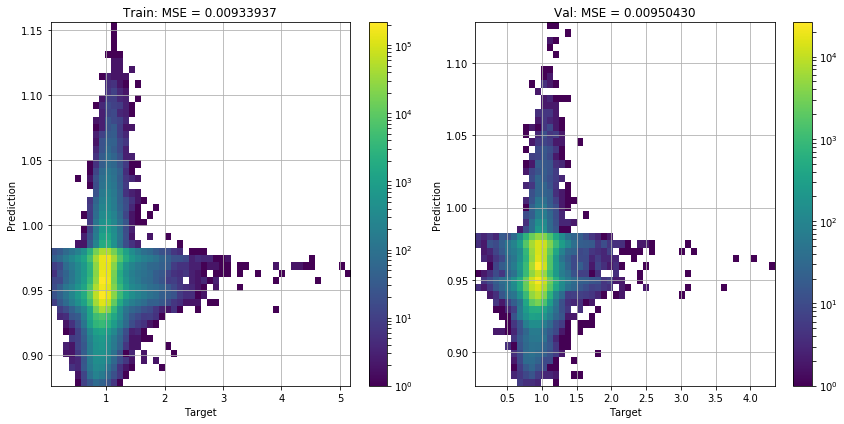

In [15]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist2d(true_train, pred_train[:,0], bins=50, norm=LogNorm())
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.hist2d(true_val, pred_val[:,0], bins=50, norm=LogNorm())
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.colorbar()

plt.tight_layout()
plt.show()

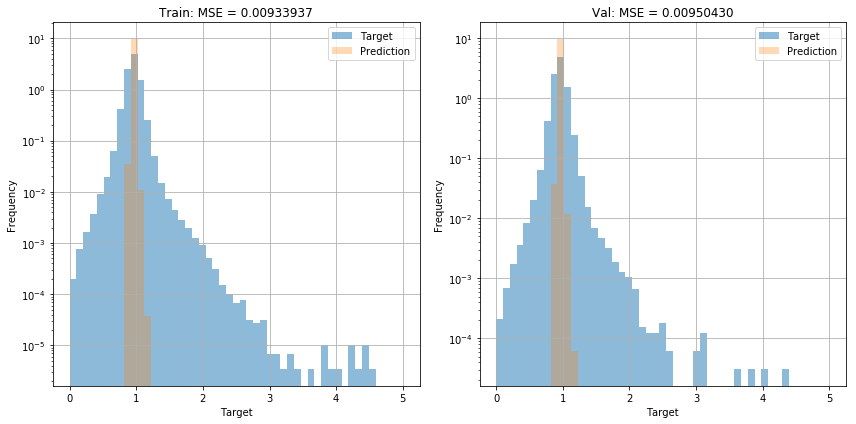

In [16]:
bins = np.linspace(0,5,50)
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist(true_train, bins, label='Target', alpha=0.5, normed=True)
plt.hist(pred_train, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.hist(true_val, bins, label='Target', alpha=0.5, normed=True)
plt.hist(pred_val, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.legend()

plt.tight_layout()
plt.show()

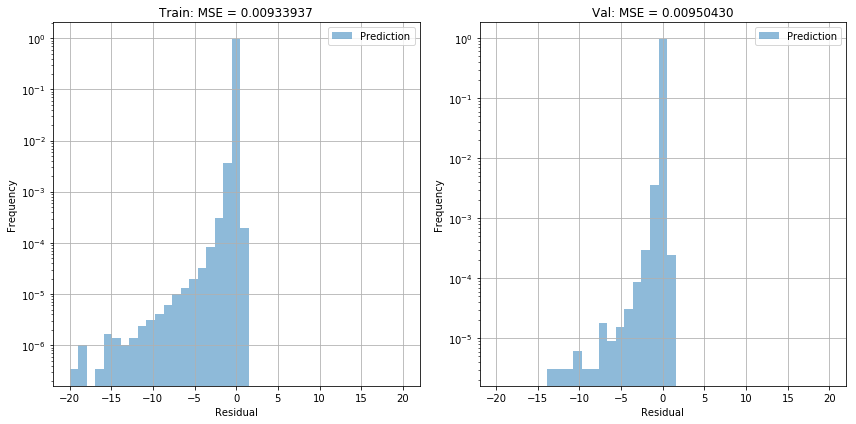

In [17]:
bins = np.linspace(-20, 20, 40)
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.hist(residual_train, bins, label='Prediction', alpha=0.5, normed=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Train: MSE = {:.8f}'.format(mse_train))
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.hist(residual_val, bins, label='Prediction', alpha=0.5, normed=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Val: MSE = {:.8f}'.format(mse_val))
plt.legend()

plt.tight_layout()
plt.show()

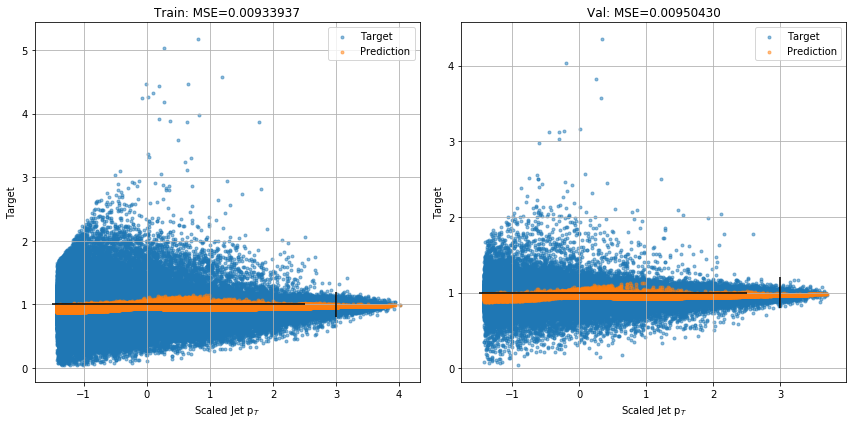

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.scatter(df_jets_train['scaled_pt'], true_train, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_train['scaled_pt'], pred_train, label='Prediction', alpha=0.5 , marker='.')
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Target')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.scatter(df_jets_val['scaled_pt'], true_val, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_val['scaled_pt'], pred_val, label='Prediction', alpha=0.5 , marker='.')
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Target')
plt.legend()

plt.tight_layout()
plt.show()

/usr/lib64/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


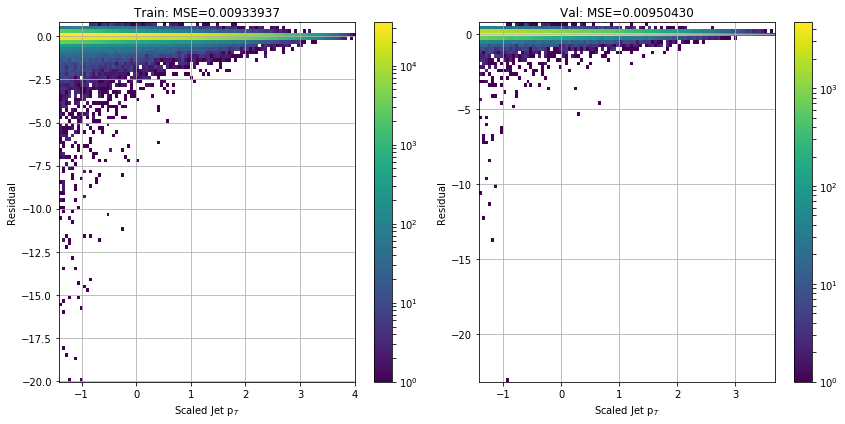

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.hist2d(df_jets_train['scaled_pt'], residual_train, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.hist2d(df_jets_val['scaled_pt'], residual_val, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet p$_{T}$')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.tight_layout()
plt.show()

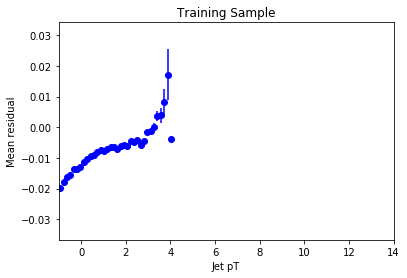

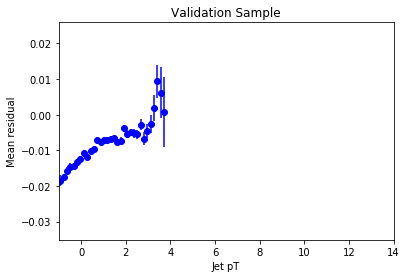

In [20]:
profile_data(df_jets_train['scaled_pt'], [residual_train], 100, -1, 14, ['b'], plabels=[''], title='Training Sample', xlabel='Jet pT', ylabel='Mean residual')
profile_data(df_jets_val['scaled_pt'], [residual_val], 100, -1, 14, ['b'], plabels=[''], title='Validation Sample', xlabel='Jet pT', ylabel='Mean residual')

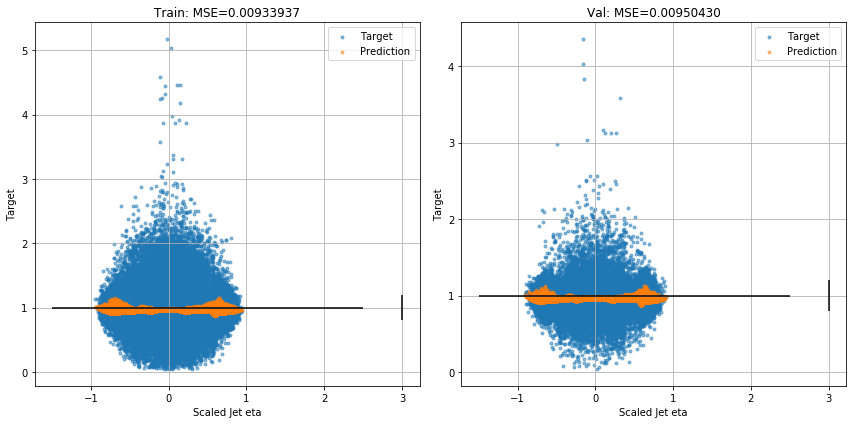

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.scatter(df_jets_train['jet_eta'], true_train, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_train['jet_eta'], pred_train, label='Prediction', alpha=0.5 , marker='.')
#plt.xlim((-1.5,2.5))
#plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Target')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.scatter(df_jets_val['jet_eta'], true_val, label='Target', alpha=0.5 , marker='.')
plt.scatter(df_jets_val['jet_eta'], pred_val, label='Prediction', alpha=0.5 , marker='.')
#plt.xlim((-1.5,2.5))
#plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Target')
plt.legend()

plt.tight_layout()
plt.show()

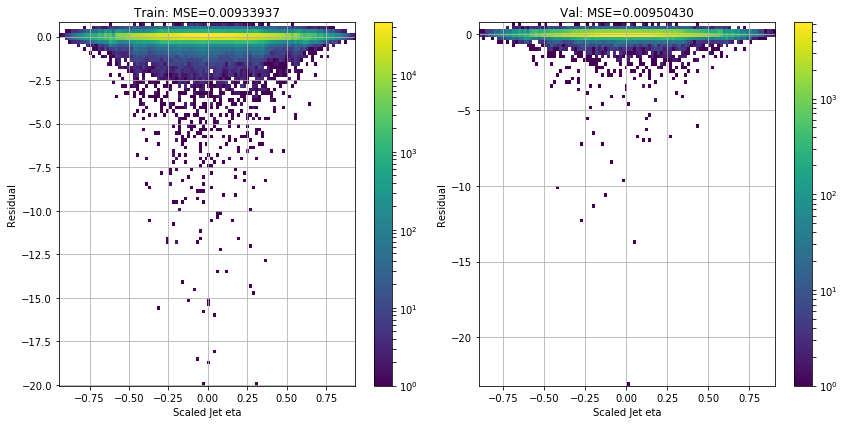

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.grid()
plt.title('Train: MSE={:.8f}'.format(mse_train))
plt.hist2d(df_jets_train['jet_eta'], residual_train, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.grid()
plt.title('Val: MSE={:.8f}'.format(mse_val))
plt.hist2d(df_jets_val['jet_eta'], residual_val, bins=100, norm=LogNorm())
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel('Scaled Jet eta')
plt.ylabel('Residual')
plt.legend()
plt.colorbar()

plt.tight_layout()
plt.show()

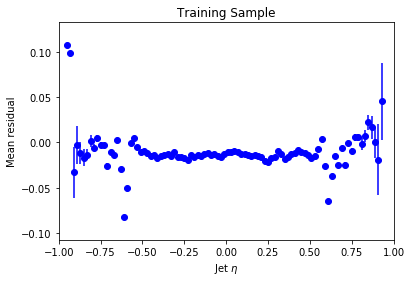

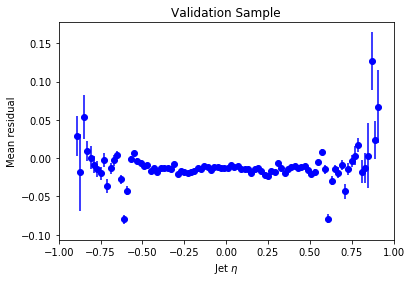

In [23]:
profile_data(df_jets_train['jet_eta'], [residual_train], 100, -1, 1, ['b'], plabels=[''], title='Training Sample', xlabel='Jet $\eta$', ylabel='Mean residual')
profile_data(df_jets_val['jet_eta'], [residual_val], 100, -1, 1, ['b'], plabels=[''], title='Validation Sample', xlabel='Jet $\eta$', ylabel='Mean residual')